Importing Libraries and Loading Data

In [12]:
import pandas as pd
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

# Load the provided Excel file
file_path = '/home/koyilada-keerti/Documents/GitHub/Articulation-Meter/Project Files/btp_list.xlsx'
data = pd.read_excel(file_path)


Adding Columns and Helper Functions

In [13]:
# Add duration and subtitle_language columns with random values for the sake of the example
np.random.seed(42)
data['duration'] = np.random.randint(100, 500, size=len(data))  # Random durations between 100 and 500 seconds
languages = ['English', 'Spanish', 'French', 'German', 'Chinese', 'Telugu', 'Hindi']
data['subtitle_language'] = np.random.choice(languages, size=len(data))  # Randomly assign one of the languages

# Helper function to safely compute mode, mean, and sum of a list represented as a string
def safe_compute_mode(series):
    return series.apply(lambda x: stats.mode(np.fromstring(x, sep=', '), keepdims=True).mode[0] if isinstance(x, str) else np.nan)

def safe_compute_mean(series):
    return series.apply(lambda x: np.mean(np.fromstring(x, sep=', ')) if isinstance(x, str) else np.nan)

def safe_compute_sum(series):
    return series.apply(lambda x: np.sum(np.fromstring(x, sep=', ')) if isinstance(x, str) else np.nan)

# Compute necessary metrics with error handling
data['shoulder_midpoints_mode'] = safe_compute_mode(data['shoulder_midpoints'])
data['head_turn_angles_mean'] = safe_compute_mean(data['head_turn_angles'])
data['left_hand_mode'] = safe_compute_mode(data['left_hand'])
data['right_hand_sum'] = safe_compute_sum(data['right_hand'])
data['left_hand_sum'] = safe_compute_sum(data['left_hand'])
data['left_right_hand_sum'] = data['left_hand_sum'] + data['right_hand_sum']


Selecting Relevant Columns and Handling Categorical Data

In [14]:
# Select relevant columns for prediction
selected_columns = ['views', 'likes', 'shoulder_midpoints_mode', 'head_turn_angles_mean', 'left_hand_mode', 'left_right_hand_sum', 'duration', 'subtitle_language']
data_selected = data[selected_columns].dropna()

# Convert categorical variable 'subtitle_language' to numerical values
data_selected = pd.get_dummies(data_selected, columns=['subtitle_language'], drop_first=True)


Filtering Features and Scaling

In [15]:
# Filter features based on correlation threshold > 0.1 with 'views'
correlation_threshold = 0.1
correlation_matrix = data_selected.corr()

# Select features with correlation > 0.1 with 'views' for prediction
features_views = correlation_matrix.index[abs(correlation_matrix['views']) > correlation_threshold].tolist()
features_views.remove('views')

# Select features with correlation > 0.1 with 'likes' for prediction
features_likes = correlation_matrix.index[abs(correlation_matrix['likes']) > correlation_threshold].tolist()
features_likes.remove('likes')

# Scale the features
scaler = StandardScaler()
data_selected[features_views] = scaler.fit_transform(data_selected[features_views])
data_selected[features_likes] = scaler.fit_transform(data_selected[features_likes])


Plotting Correlation Matrix

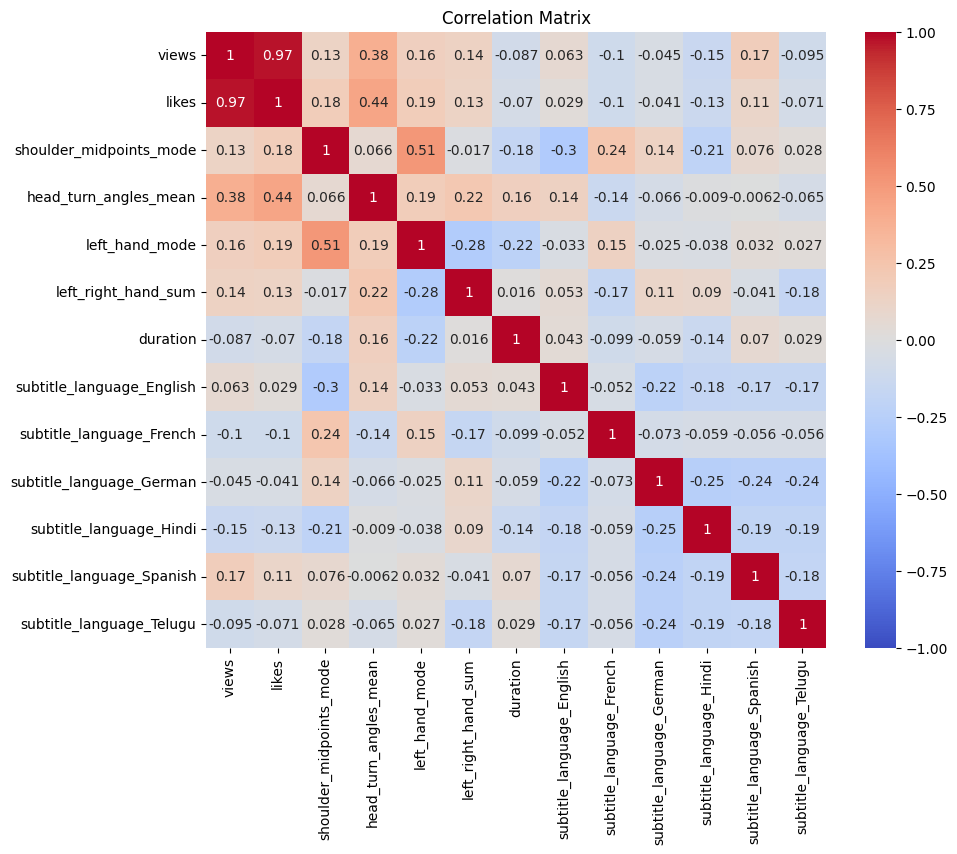

In [16]:
# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()


Function for Training and Evaluating Models

In [17]:
# Function to train and evaluate a model
def train_evaluate_model(X, y, model_name='Linear Regression'):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    if model_name == 'Linear Regression':
        model = LinearRegression()
    elif model_name == 'Ridge Regression':
        model = Ridge(alpha=1.0)
    elif model_name == 'Lasso Regression':
        model = Lasso(alpha=0.1)
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f'{model_name} - Mean Absolute Error: {mae}')
    print(f'{model_name} - Mean Squared Error: {mse}')
    print(f'{model_name} - Root Mean Squared Error: {rmse}')
    print(f'{model_name} - R^2 Score: {r2}')
    
    # Plotting actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test, y_pred, alpha=0.7)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--r')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values ({model_name})')
    plt.show()
    
    # Plotting residual errors
    plt.figure(figsize=(10, 6))
    sns.histplot(y_test - y_pred, bins=30, kde=True)
    plt.xlabel('Residual Error')
    plt.title(f'Distribution of Residuals ({model_name})')
    plt.show()
    
    return model


Training and Evaluating Model for 'Views'

Linear Regression - Mean Absolute Error: 0.1665100121121246
Linear Regression - Mean Squared Error: 0.04059025613749679
Linear Regression - Root Mean Squared Error: 0.2014702363563829
Linear Regression - R^2 Score: 0.8916695924924238


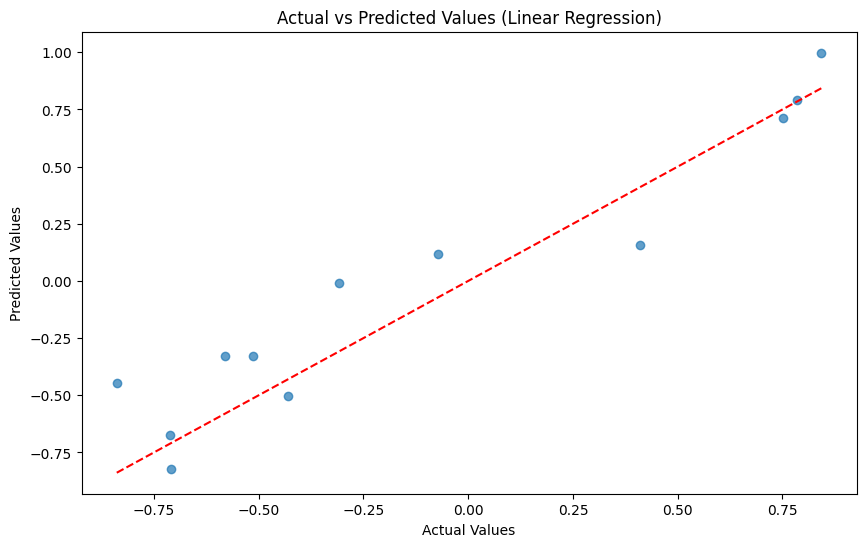

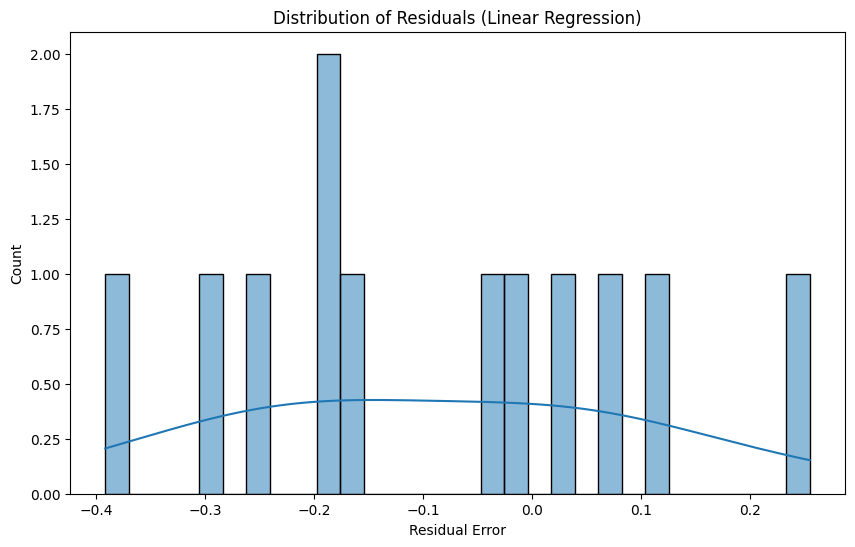

In [20]:
# Prepare the feature matrix (X) and target vector (y) for predicting views
X_views = data_selected[features_views]
y_views = data_selected['views']

# Train and evaluate the model for views
model_views = train_evaluate_model(X_views, y_views, model_name='Linear Regression')


Training and Evaluating Model for 'Likes'

Linear Regression - Mean Absolute Error: 0.152799257511478
Linear Regression - Mean Squared Error: 0.03508293199554154
Linear Regression - Root Mean Squared Error: 0.18730438327904006
Linear Regression - R^2 Score: 0.9133493949492878


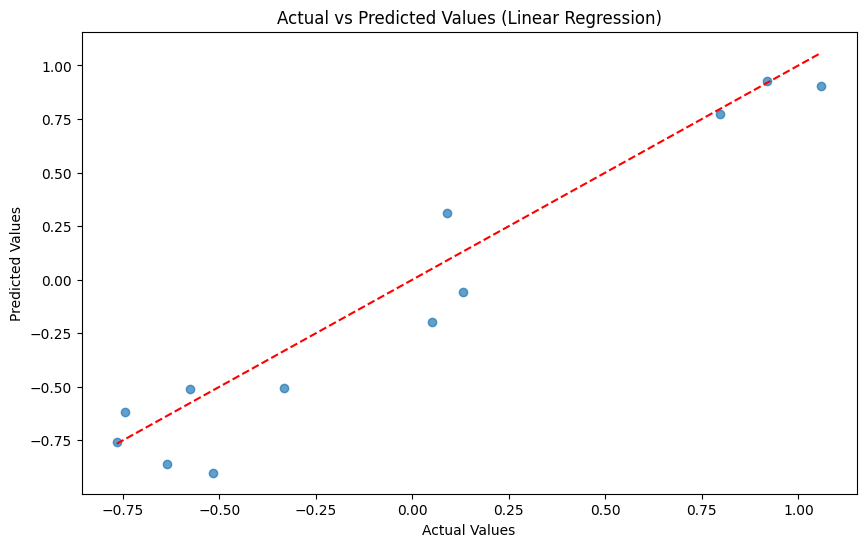

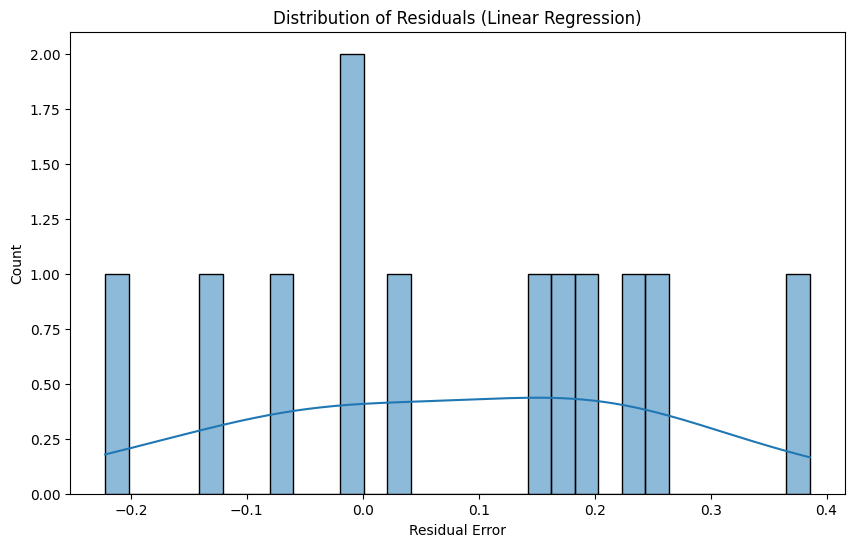

In [21]:
# Prepare the feature matrix (X) and target vector (y) for predicting likes
X_likes = data_selected[features_likes]
y_likes = data_selected['likes']

# Train and evaluate the model for likes
model_likes = train_evaluate_model(X_likes, y_likes, model_name='Linear Regression')
